In [1]:
##### import tensorflow as tf
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop,Adam

import matplotlib.pyplot as plt
%matplotlib inline

/home/gopi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""
Loading MNIST Dataset
"""

def load_mnist():
    (x_train,y_train), (x_test,y_test) = mnist.load_data()
    
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.

    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))

    return (x_train, y_train), (x_test, y_test)

In [3]:
"""
Initial CNN Model
"""
def build_simple_model():
    inputs = layers.Input(shape=(28,28,1))
    x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', name="Conv1")(inputs)
    x = layers.Conv2D(64, kernel_size=(3,3), activation='relu', name="Conv2")(x)
    
    x = layers.MaxPooling2D(pool_size=(2,2), name='MaxPool')(x)
    x = layers.Dropout(rate=0.25, name='Dropout1')(x)
    
    x = layers.Flatten(name='Flat')(x)
    x = layers.Dense(128, activation='relu', name='FC1')(x)
    x = layers.Dropout(rate=0.5, name='Dropout2')(x)

    
    x = layers.Dense(10, name='logits')(x)
    preds = layers.Activation('softmax', name='Softmax')(x)

    model = Model(inputs=inputs, outputs=preds)
    model.summary()
    return model

In [4]:
model = build_simple_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
Conv2 (Conv2D)               (None, 24, 24, 64)        18496     
_________________________________________________________________
MaxPool (MaxPooling2D)       (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 12, 12, 64)        0         
_________________________________________________________________
Flat (Flatten)               (None, 9216)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               1179776   
__________

In [ ]:
(x_train, y_train), (x_test, y_test) = load_mnist()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=512)  

Epoch 1/10
 1536/60000 [..............................] - ETA: 18:16 - loss: 2.1586 - acc: 0.3014

In [7]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

10000/10000 [==============================] - 5s 545us/step
Test Loss: 0.03430916118031746
Test Accuracy: 0.9884


In [8]:
"""
Softmax with Temperature
"""

def softmax_with_temperature(logits, temperature=1):
    logits = logits / temperature
    return np.exp(logits) / np.sum(np.exp(logits))

In [9]:
model_prev_softmax = Model(inputs=model.input, outputs=model.get_layer("logits").output)
model_logits = model_prev_softmax.predict(x_train)

In [10]:
unsoftened_train_prob = softmax_with_temperature(model_logits, 1)

In [11]:
def plot_mnist_image(img_arr):
  plt.imshow(img_arr.reshape([28, 28]))

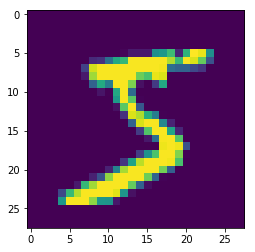

In [12]:
plot_mnist_image(x_train[0])

In [13]:
print("Unsoftened probabilities: ", unsoftened_train_prob[0])
print()
print("Prediction based on unsoftened probability: ", np.argmax(unsoftened_train_prob[0]))

Unsoftened probabilities:  [1.2512286e-16 1.3515365e-15 3.9405431e-16 1.3119422e-10 1.9544782e-16
 6.8480372e-09 2.6516942e-14 1.3813276e-14 3.4258627e-14 1.3671341e-13]

Prediction based on unsoftened probability:  5


In [14]:
temperature = 4
softened_train_prob = softmax_with_temperature(model_logits, temperature)

In [15]:
print("Softened probabilities: ", softened_train_prob[0])
print()
print("Prediction based on Softened probability: ", np.argmax(softened_train_prob[0]))

Softened probabilities:  [5.1590593e-08 9.3528350e-08 6.8726678e-08 1.6508782e-06 5.7675859e-08
 4.4373928e-06 1.9684174e-07 1.6722858e-07 2.0985958e-07 2.9661228e-07]

Prediction based on Softened probability:  5


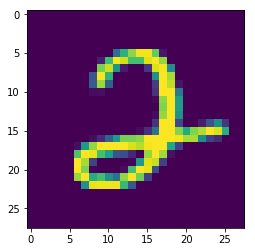

In [16]:
plot_mnist_image(x_train[16])

In [17]:
print("Softened probabilities: ", softened_train_prob[16])
print()
print("Prediction based on softened probability: ", np.argmax(softened_train_prob[16]))

Softened probabilities:  [2.1526787e-07 6.7508154e-08 9.8014007e-06 3.4076433e-07 6.0945318e-08
 8.7571721e-08 3.4415706e-08 9.5475548e-07 3.2501762e-07 9.4076306e-08]

Prediction based on softened probability:  2


In [18]:
def build_small_model():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Flatten()(inputs)
    x = layers.Dense(128, activation='relu', name='FC1')(x)
    x = layers.Dense(128, activation='relu', name='FC2')(x)
    x = layers.Dense(10, name='logits')(x)
    preds = layers.Activation('softmax', name='Softmax')(x)

    model = Model(inputs=inputs, outputs=preds)
    model.summary()
    return model

In [19]:
small_model = build_small_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               100480    
_________________________________________________________________
FC2 (Dense)                  (None, 128)               16512     
_________________________________________________________________
logits (Dense)               (None, 10)                1290      
_________________________________________________________________
Softmax (Activation)         (None, 10)                0         
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [21]:
small_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
small_model.fit(x_train, y_train, epochs=30, batch_size=512)

Epoch 1/30
60000/60000 [==============================] - 1s 16us/step - loss: 0.0371 - acc: 0.9892
Epoch 2/30
60000/60000 [==============================] - 1s 16us/step - loss: 0.0318 - acc: 0.9911
Epoch 3/30
60000/60000 [==============================] - 1s 17us/step - loss: 0.0285 - acc: 0.9925
Epoch 4/30
60000/60000 [==============================] - 1s 15us/step - loss: 0.0242 - acc: 0.9941
Epoch 5/30
60000/60000 [==============================] - 1s 15us/step - loss: 0.0201 - acc: 0.9949
Epoch 6/30
60000/60000 [==============================] - 1s 15us/step - loss: 0.0203 - acc: 0.9947
Epoch 7/30
60000/60000 [==============================] - 1s 16us/step - loss: 0.0165 - acc: 0.9961
Epoch 8/30
60000/60000 [==============================] - 1s 15us/step - loss: 0.0131 - acc: 0.9974
Epoch 9/30
60000/60000 [==============================] - 1s 16us/step - loss: 0.0121 - acc: 0.9974
Epoch 10/30
60000/60000 [==============================] - 1s 15us/step - loss: 0.0099 - acc: 0.9981

In [32]:
test_loss, test_acc = small_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

10000/10000 [==============================] - 0s 29us/step
Test Loss: 0.10984879909294341
Test Accuracy: 0.9758


In [28]:
"""
Knowledge Transfering
"""

new_small_model = build_small_model()
logits = new_small_model.get_layer('logits').output
logits = layers.Lambda(lambda x: x / temperature, name='Temperature')(logits)
preds = layers.Activation('softmax', name='Softmax')(logits)
  
new_small_model = Model(inputs=new_small_model.input, outputs=preds)
print("New Model Summary")
new_small_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               100480    
_________________________________________________________________
FC2 (Dense)                  (None, 128)               16512     
_________________________________________________________________
logits (Dense)               (None, 10)                1290      
_________________________________________________________________
Softmax (Activation)         (None, 10)                0         
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
New 

In [29]:
new_small_model.compile(optimizer=Adam(lr=0.03), loss='categorical_crossentropy', metrics=['accuracy'])
new_small_model.fit(x_train, softened_train_prob, epochs=10, batch_size=512)

Epoch 1/10
60000/60000 [==============================] - 1s 22us/step - loss: 1.9514e-05 - acc: 0.7014
Epoch 2/10
60000/60000 [==============================] - 1s 16us/step - loss: 1.2487e-05 - acc: 0.9153
Epoch 3/10
60000/60000 [==============================] - 1s 18us/step - loss: 1.1951e-05 - acc: 0.9390
Epoch 4/10
60000/60000 [==============================] - 1s 15us/step - loss: 1.1697e-05 - acc: 0.9518
Epoch 5/10
60000/60000 [==============================] - 1s 15us/step - loss: 1.1544e-05 - acc: 0.9609
Epoch 6/10
60000/60000 [==============================] - 1s 16us/step - loss: 1.1453e-05 - acc: 0.9666
Epoch 7/10
60000/60000 [==============================] - 1s 18us/step - loss: 1.1389e-05 - acc: 0.9709
Epoch 8/10
60000/60000 [==============================] - 1s 16us/step - loss: 1.1344e-05 - acc: 0.9746
Epoch 9/10
60000/60000 [==============================] - 1s 17us/step - loss: 1.1312e-05 - acc: 0.9765
Epoch 10/10
60000/60000 [==============================] - 1s 16

In [30]:
test_loss, test_acc = new_small_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

10000/10000 [==============================] - 0s 36us/step
Test Loss: 0.3040420033931732
Test Accuracy: 0.974
